In [1]:
import os
import sys
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import pydotplus

from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error


In [2]:

    
class DataLoader:

    def __init__(self) -> None:
        pass

    def load_data_from_file(self, csv_path, start_date=None, end_date=None):
        data = pd.read_csv(csv_path)
        if start_date and end_date:
            return self.filter_data(data, start_date=start_date, end_date=end_date)
        else:
            return data
    
    def filter_data(self, data, start_date, end_date):
        return data[(data["Date_time"] >= start_date) & (data["Date_time"] <= end_date)]
    
    
class DataManager:

    def __init__(self) -> None:
        self.data_loader = DataLoader()

    def get_data(self, target_feature, start_date=None, end_date=None):
        data = self.data_loader.load_data(start_date=start_date, end_date=end_date)
        return self.prepare_data(data, target_feature=target_feature)

    def get_features(self):
        return ["Ba_avg","P_avg","Q_avg","Ya_avg","Yt_avg","Ws1_avg","Ws2_avg","Ws_avg","Wa_avg","Va_avg","Ot_avg","Rs_avg","Rbt_avg","Rm_avg","temp","pressure","humidity","wind_speed","wind_deg","rain_1h","snow_1h"]

    def prepare_data(self, data, target_feature, features=None):
        if features is None:
            features = self.get_features()
        data = data[features]
        X = data.drop(columns=target_feature).values
        y = data[target_feature].values
        return X, y

    def split_data(self, data, test_size=0.2):
        train, test = train_test_split(data, test_size=test_size, shuffle=False)
        return train, test
    
    def split_data_by_date(self, data, test_date):
        train = data[data.index<test_date]
        test = data[data.index>test_date]
        return train, test


class ModelLoader:

    def __init__(self, model) -> None:
        # TODO: detect model type
        self.model = model
        self.model_type = "sklearn"

    def predict(self, X):
        return self.model.predict(X)


class Modeler:

    def __init__(self) -> None:
        self.model = None

        self.build_model()

    def build_model(self):
        self.model = GradientBoostingRegressor()

    def train(self, X, y):
        return self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)
    
    def test(self, X, y):
        preds = self.predict(X)
        metrics = self.calculate_metrics(preds, y)
        return metrics

    def calculate_metrics(self, y, preds):
        mape = mean_absolute_percentage_error(y, preds)
        return {"MAPE": mape}

class Reporter:

    def __init__(self) -> None:
        self.path = "results"
        shutil.rmtree(self.path, ignore_errors=True)
        os.makedirs(self.path)
    
    def load_model(self, model):
        return ModelLoader(model)
    
    def make_predictions(self, model, X, y):
        return y, self.load_model(model).predict(X)

    def generate_reports(self, model, X, y, title="reports"):
        y_true, y_pred = self.make_predictions(model, X, y)
        
        self.generate_results(y_true, y_pred, title=title)
        self.generate_plots(y_true, y_pred, title=title)
    
    def generate_results(self, y_true, y_pred, title="result"):

        mae = mean_absolute_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred)

        results = {
            "MAE": mae,
            "MAPE": mape,
        }

        with open(os.path.join(self.path, "info.txt"), 'a') as f:
            f.write(f"{title}: {results}\n")

    def generate_plots(self, y_true, y_pred, title="plot"):
        data = pd.DataFrame({"pred": y_pred, "true": y_true})
        data.reset_index(inplace=True, drop=True)
        plt.clf()
        for col in data.columns:
            if col.lower().startswith('pred'):
                data[col].plot(label=col,linestyle="dotted")
            else:
                data[col].plot(label=col)
        plt.title(title)
        plt.legend()
        plt.savefig(os.path.join(self.path, title + ".jpg"))

    def generate_tables(self, y_true, y_pred, title="tabel"):
        pd.DataFrame({"true": y_true, "pred": y_pred}).to_csv(title+".csv", index=False)

    def visualize_tree(self, model):
        
        # Get the tree number 42
        clf = model
        sub_tree_42 = clf.estimators_[42, 0]

        # Visualization
        # Install graphviz: https://www.graphviz.org/download/
        from pydotplus import graph_from_dot_data
        from IPython.display import Image
        dot_data = export_graphviz(
            sub_tree_42,
            out_file=None, filled=True, rounded=True,
            special_characters=True,
            proportion=False, impurity=False, # enable them if you want
        )
        graph = graph_from_dot_data(dot_data)
        image = Image(graph.create_png())
        with open("temp.png", "wb") as png:
            png.write(image.data)
            

class SCM:

    def __init__(self) -> None:
        self.data_loader = DataLoader()
        self.data_manager = DataManager()
        self.modeler = Modeler()
        self.reporter = Reporter()


    def run(self, start_date=None, end_date=None, test_date=None):

        # data
        data = self.data_loader.load_data_from_file(data_path)
        
        # manage
        train_data, test_data = self.data_manager.split_data(data, test_size=split_rate)
        features= ["P_avg", "Rm_avg"] #Cm_avg
        custom_report = pd.DataFrame({"Date_time": test_data["Date_time"]}).reset_index()
        for f in features:
            X_train, y_train = self.data_manager.prepare_data(train_data, target_feature=f)
            X_test, y_test = self.data_manager.prepare_data(test_data, target_feature=f)

            # model
            model = self.modeler.train(X_train, y_train)

            # report
            self.reporter.generate_reports(model, X_test, y_test, title=f)

            # custom reports
            y_true, y_pred = self.reporter.make_predictions(model, X_test, y_test)
            custom_report = pd.concat([custom_report, pd.DataFrame({f"{f}_pred": y_pred, f"{f}_true": y_true})], axis=1)
        
        custom_report.to_csv(os.path.join(self.reporter.path, "custom_report.csv"), index=False)
        self.reporter.visualize_tree(model)
        

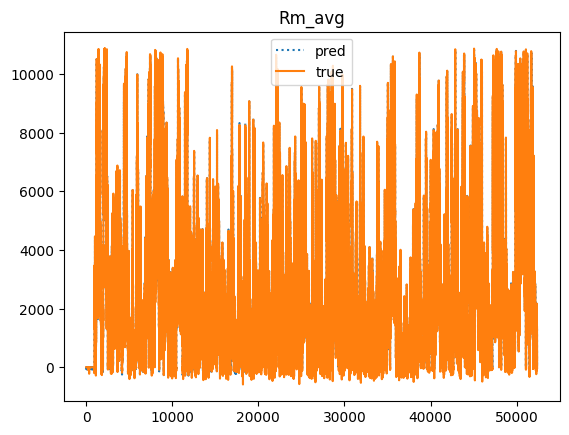

In [3]:

split_rate = 0.2
data_path = "data/R80711.csv"

scm = SCM()
scm.run()

In [46]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)



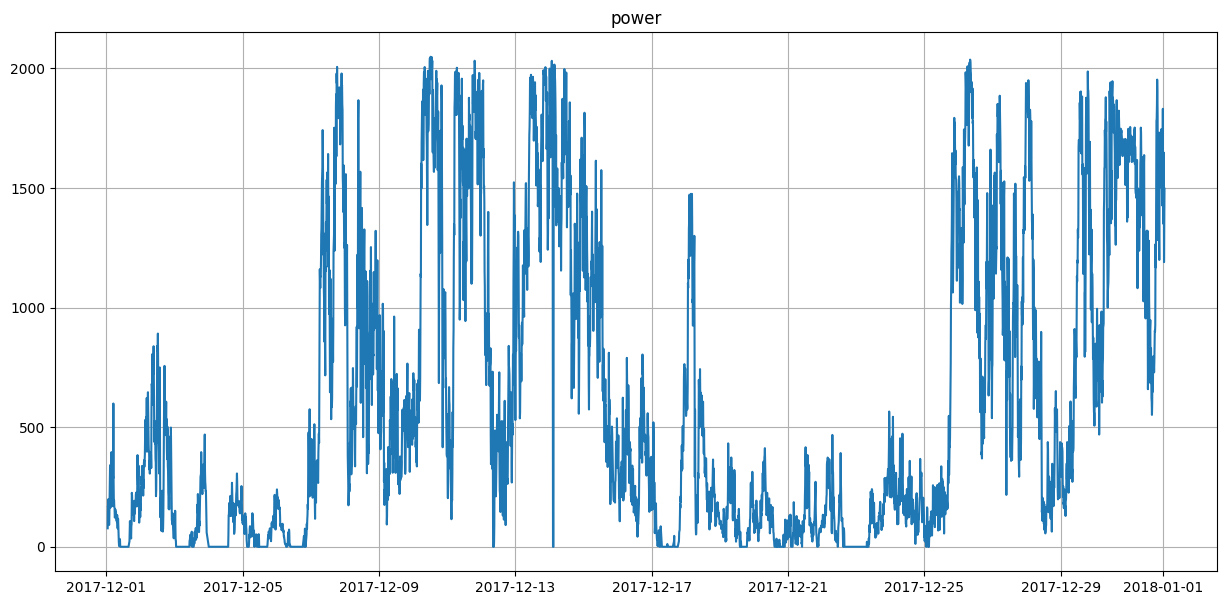

In [45]:

start_date = datetime.datetime(2017, 12, 1, tzinfo=datetime.timezone.utc)
end_date = datetime.datetime(2018, 1, 1, tzinfo=datetime.timezone.utc)


data = pd.read_csv(data_path, index_col=['Date_time'], parse_dates=['Date_time'])
data = data[(data.index >= start_date) & (data.index <= end_date)]

# data["P_avg"].plot()

plt.figure(figsize=(15, 7))
plt.plot(data.P_avg)
plt.title('power')
plt.grid(True)
plt.show()


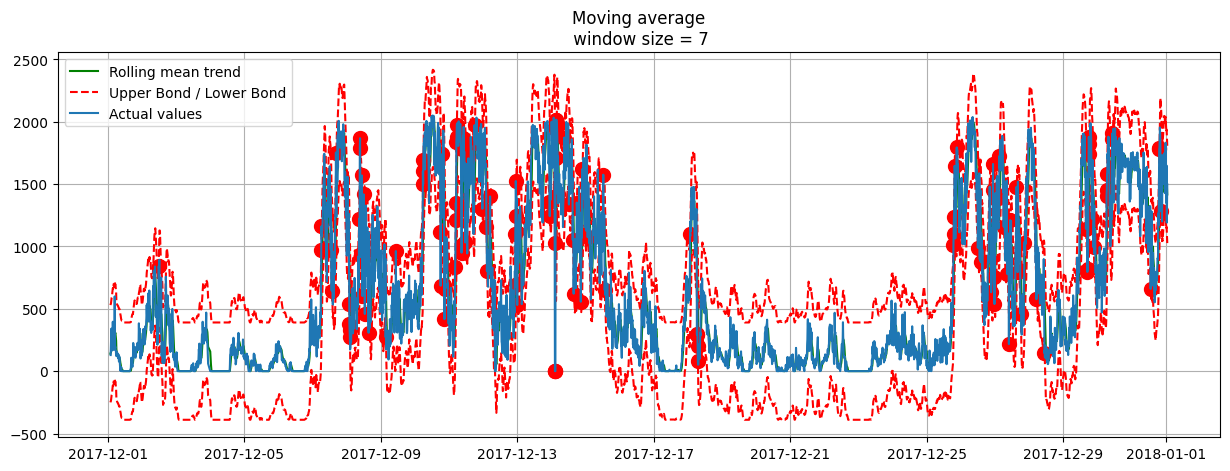

In [54]:
plotMovingAverage(pd.DataFrame(data["P_avg"]), 7, plot_intervals=True, plot_anomalies=True)